# Search Evaluation Notebook

This python notebook will perform a search evaluation
Prerequisites:
* Golden data set in file ```golden_data.csv```
* Search strategies in python modules located in the ```strategies``` folder
* ```.env``` file with the following:

```
ES_SERVER="https://YOUR_ELASTICSEARCH_8_17_or_higher:443"
ES_API_KEY="ENCODED_API_KEY"

PROXY_BASE_URL="YOUR_KEY"
OPENAI_API_KEY="YOUR_KEY"
COHERE_KEY="YOUR_KEY"
```

In [21]:
## Set up the environment variables before importing utilities
from dotenv import load_dotenv
load_dotenv()


True

In [22]:
## Run the Evaluation

from utility.util_es import get_es
from utility.util_vis_result import vis_search_eval_json, vis_deep_eval_correct_tests
from evaluate import run_evaluation, load_golden_data, load_strategies, output_eval_results

GOLDEN_DATA_CSV = "golden_data.csv"
STRATEGIES_FOLDER = "strategies"
OUTPUT_CSV = "search_evaluation_results.csv"
OUTPUT_JSON = "search_evaluation_results.json"

# 1. Connect to Elasticsearch
es = get_es()
print(f"\tConnected to Elasticsearch version: {es.info()['version']['number']}")

# 2. Load the golden data set
golden_data = load_golden_data(GOLDEN_DATA_CSV)
print(f"Identified {len(golden_data)} golden data entry(ies) to use for search evaluation")

# 3. Load strategies from the strategies folder
strategy_modules = load_strategies(STRATEGIES_FOLDER)  
print(f"Identified {len(strategy_modules)} strategy(ies) to evaluate")

# 4. Evaluate each strategy
results = run_evaluation(es, golden_data, strategy_modules)

# 5. Output the evaluation results
output_eval_results(OUTPUT_CSV, OUTPUT_JSON, results, golden_data, strategy_modules)



	Connected to Elasticsearch version: 8.17.0
Identified 17 golden data entry(ies) to use for search evaluation
Identified 1 strategy(ies) to evaluate
### SEARCH RANK EVAL
	Starting strategy: 1_default_bm25
Evaluation complete. Results written to search_evaluation_results.csv and search_evaluation_results.json


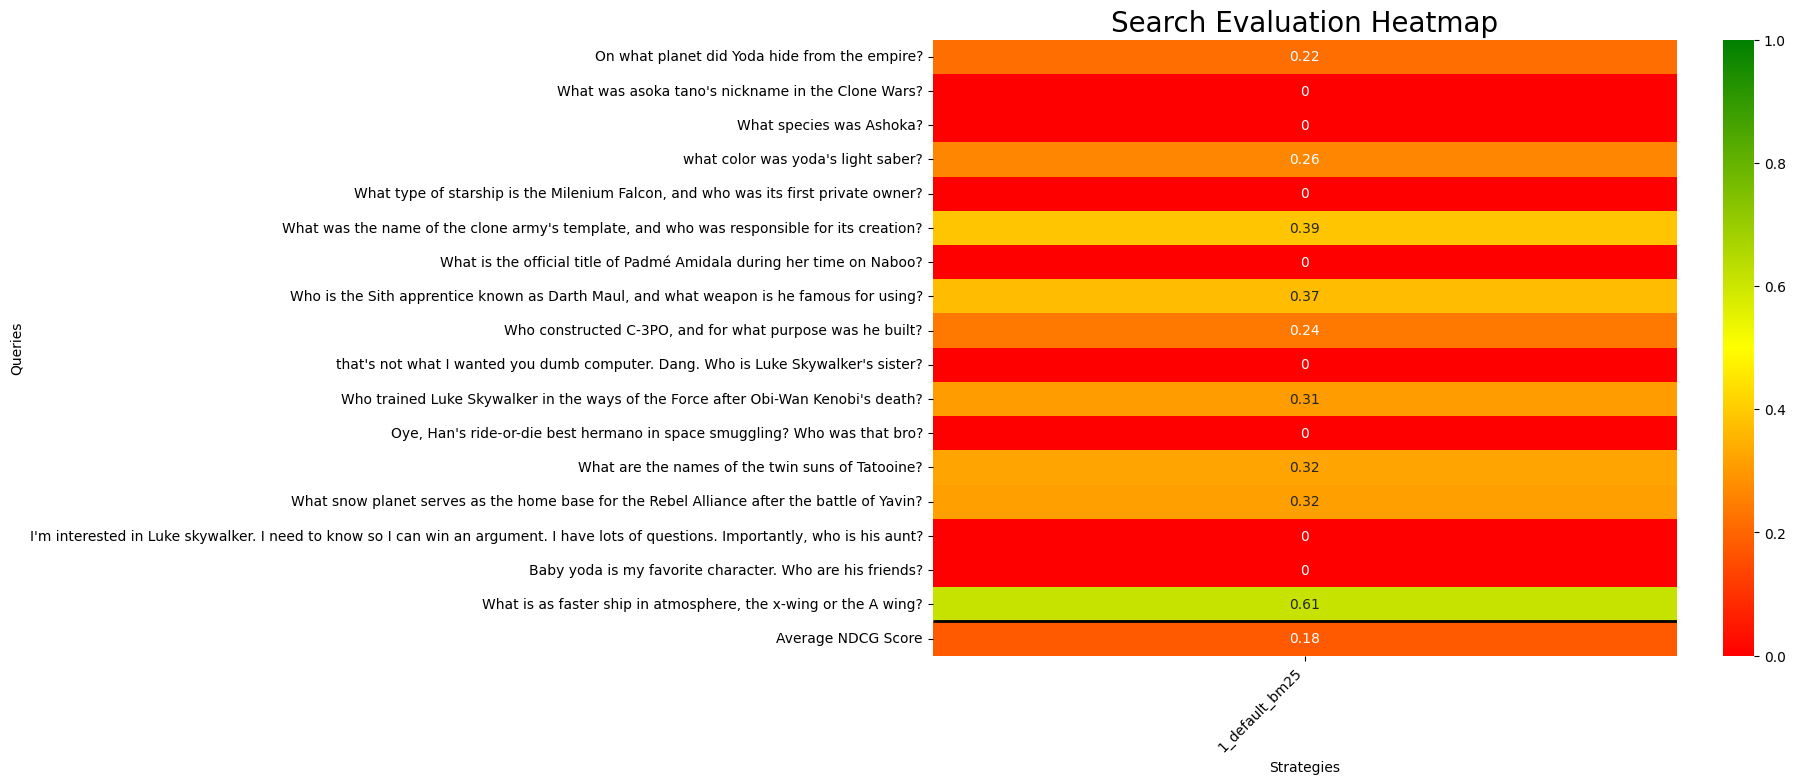

In [23]:
## Visualize the Results of the Evaluation
# 6. Visualize
vis_search_eval_json(OUTPUT_JSON)

In [24]:
from utility.util_deep_eval import generateLLMTestCase, evaluateTestCases
from deepeval.evaluate import TestResult
from utility.util_llm import LLMUtil
from utility.util_es import search_to_context
import os
import json
openai_api_key = os.getenv("OPENAI_API_KEY")

# startegies to Evauate
# include_strategy_names = ["3b_e5_hybrid", "3b_e5_hybrid_qt"]


## Deep Eval Evaluation
print("### DEEP EVAL")
deepEvalScores = {}
for strategy_name, module in strategy_modules.items():
    llm_util = LLMUtil(openai_api_key)
    # if strategy_name not in include_strategy_names:
    #     continue

    if hasattr(module, "is_disabled") and module.is_disabled(): ## or strategy_name != "1a_bm25" :
        print(f"Skipping strategy: {strategy_name}")
        continue

    print(f"Starting strategy: {strategy_name}")
    testCases = []
    for i, item in enumerate(golden_data):
            qid = f"query_{i+1}"
            query = item["query"]


            ## correct answer from the golden data
            correct_answer = item["natural_answer"]

            ## pre-process the query string
            query_string = module.query_transform(query, llm_util,  module.get_parameters()["query_transform_prompt"]) if hasattr(module, "query_transform") else query

            ## do the RAG
            index_name = module.get_parameters()['index_name']
            body = module.build_query(query_string)
            rag_context = module.get_parameters().get("rag_context", "lore")
            
            retrieval_context  = search_to_context(es, index_name, body, rag_context, 3)
            context = "\n\n".join(retrieval_context)
            # print(f"Context: {context}")

#             system_prompt = f"""
# Instructions:

# - You are an assistant for question-answering tasks.
# - Use the context below to answer the question.


# Context:
# {context}
# """

            system_prompt = f"""
Instructions:

- You are an assistant for question-answering tasks.
- Answer questions truthfully and factually using only the context presented.
- If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
- You are correct, factual, precise, and reliable.


Context:
{context}
"""
                
            actual_output = llm_util.rag_cache(system_prompt, retrieval_context, query_string)


            ## fill in query and strategy responses in score sheet
            stratResult = {"actual_output": actual_output, "retrieval_context": retrieval_context}
            if qid not in deepEvalScores:
                deepEvalScores[qid] = { 
                    "query" : query, 
                    "correct_answer": correct_answer,
                    "strategies": { strategy_name: stratResult} }
            else:
                deepEvalScores[qid]["strategies"][strategy_name] = stratResult

            ## prep deel eval test case for later batch evaluation
            testCase = generateLLMTestCase(qid, query, actual_output, retrieval_context, correct_answer)
            testCases.append(testCase)

    ## Run evaluations for this strategy      
    rag_evaluation = evaluateTestCases(testCases)

    for test_result in  rag_evaluation.test_results:
        quid = test_result.name

        success = test_result.success
        scores = {"success": success}
        # print(f"name: {quid} | success: {success}")
        for metric in  test_result.metrics_data:
            # print(f"{metric.name} : score {metric.score} | {metric.reason}")
            scores[metric.name] = {"score": metric.score, "reason": metric.reason }
        
        deepEvalScores[quid]["strategies"][strategy_name]["scores"] = scores
    
    llm_util.flush_cache()
        
        

## save the scores to disk
# print(json.dumps(deepEvalScores, indent=2))
with open("deepeval_results.json", "w") as f:
    json.dump(deepEvalScores, f, indent=2)




### DEEP EVAL
Starting strategy: 1_default_bm25
	RAG answer: Yoda hid from the Empire on the planet Dagobah.
	RAG answer: Ahsoka Tano's nickname in the Clone Wars was "Snips." This nickname was given to her by her Jedi Master, Anakin Skywalker, due to her snippy attitude when they first met.
	RAG answer: Ahsoka Tano was a Togruta, a species known for their distinctive head-tails, or montrals, and colorful skin patterns.
	RAG answer: Yoda's lightsaber was powered by a green kyber crystal, giving it a green blade.
	RAG answer: The Millennium Falcon is a YT-1300 light freighter. The context does not provide information about its first private owner.
	RAG answer: The clone army's template was Jango Fett, a human bounty hunter. The creation of the clone army was commissioned by Jedi Master Sifo-Dyas.
	RAG answer: During her time on Naboo, Padmé Amidala held the official title of Queen of Naboo.
	RAG answer: Darth Maul is a former Sith apprentice who was known for his distinctive double-blad

✨ You're running DeepEval's latest Correctness (GEval) Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 17 test case(s) in parallel: |██████████|100% (17/17) [Time Taken: 00:02,  5.72test case/s]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

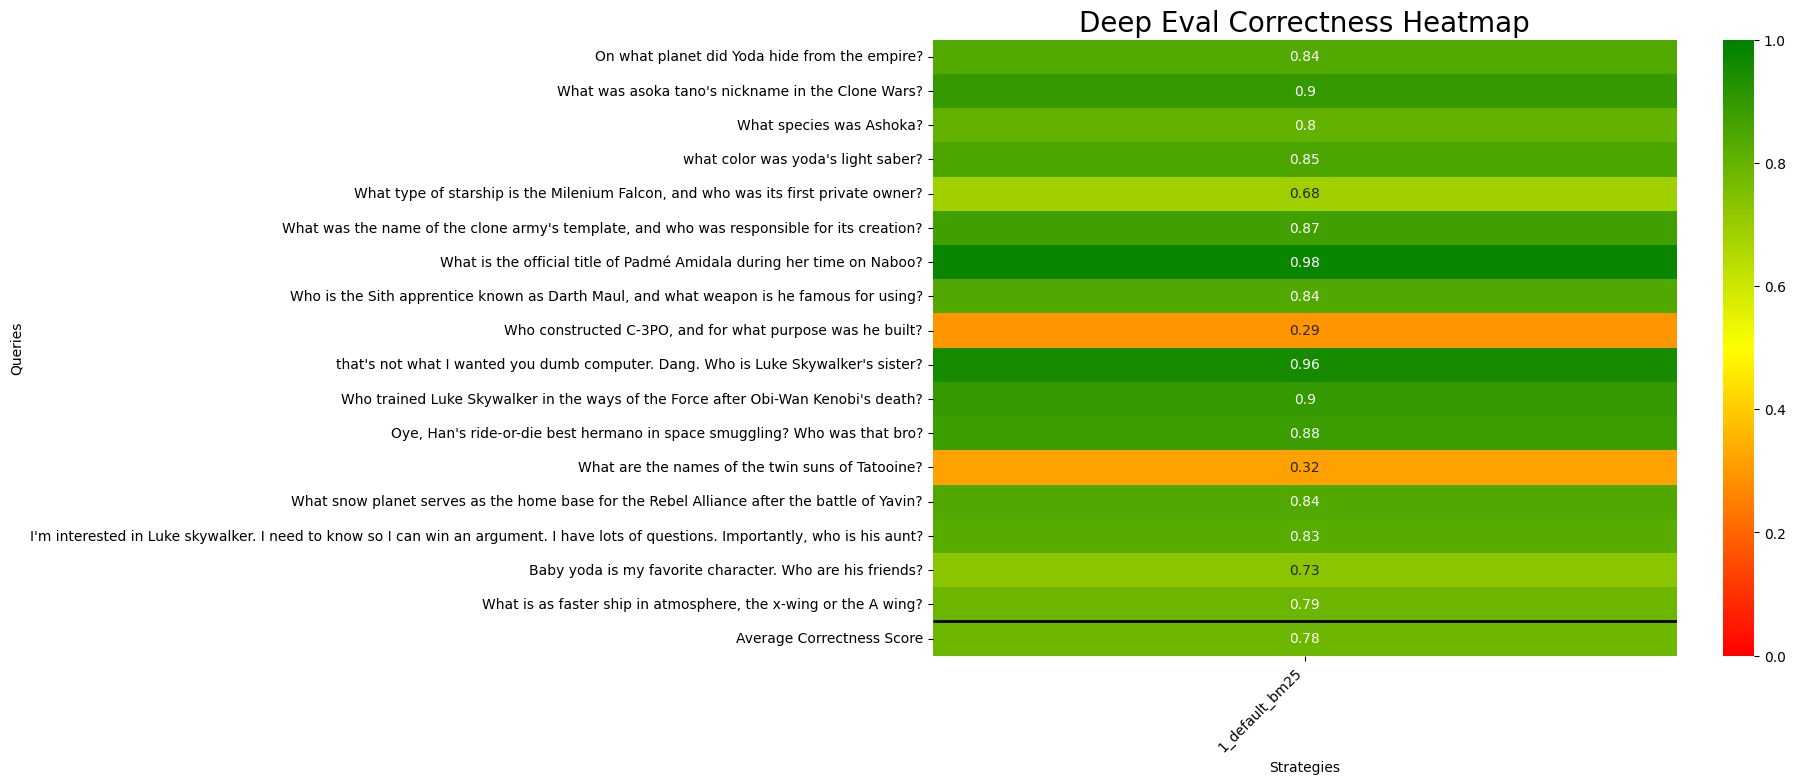

In [25]:
# 6. Visualize
vis_deep_eval_correct_tests("deepeval_results.json")